In [84]:
%matplotlib inline
import pandas as pd
import re
from datetime import datetime, timedelta
import os
import numpy as np
import matplotlib.pyplot as plt

# Function to extract a timestamp from the file name
def extract_timestamp(filename):
    # Adjust this regex pattern to match the timestamp format in the filename
    pattern = r'(\d{4}-\d{2}-\d{2}T\d{2}_\d{2}_\d{2})'
    match = re.search(pattern, filename)
    if match:
        return datetime.strptime(match.group(1), '%Y-%m-%dT%H_%M_%S')
    else:
        return None

# Function to get files close to a given timestamp
def get_close_files(file_list, target_timestamp, delta=timedelta(seconds=2)):
    close_files = []
    for filename in file_list:
        file_timestamp = extract_timestamp(filename)
        if file_timestamp and abs(file_timestamp - target_timestamp) < delta:
            close_files.append(filename)
    return close_files

def get_files_to_load(file_list, load_patterns):
    return [str1 for str1 in file_list if any(substring in str1 for substring in load_patterns)]

def read_and_interpolate_files(file_list):
    
    # Read the data from files
    dfs = [pd.read_csv(file, dtype='float64') for file in file_list]
    
    # Merge the two first dataframes on the timestamp column
    merged_df = pd.merge_asof(dfs[0], dfs[1], on='Timestamp', direction='backward')
    
    for df in dfs[2:]:    
        merged_df = pd.merge_asof(merged_df, df, on='Timestamp', direction='backward')

    return merged_df
        
# Function to read and process time-stamped data
def read_and_interpolate(file1, file2):
    # Read the data from the files
    df1 = pd.read_csv(file1, parse_dates=['Timestamp'])
    df2 = pd.read_csv(file2, parse_dates=['Timestamp'])
    
    # Ensure that timestamps are sorted
    df1 = df1.sort_values('Timestamp')
    df2 = df2.sort_values('Timestamp')
    
    # Merge the two dataframes on the timestamp column
    merged_df = pd.merge_asof(df1, df2, on='Timestamp', direction='backward')
    
    # Interpolate missing values
    merged_df.interpolate(method='ffill', inplace=True)
    
    return merged_df



def get_data(directory, target_timestamp, load_patterns):
    
    # List files in the directory
    file_list = os.listdir(directory)

    # Get files close to the target timestamp
    close_files = get_close_files(file_list, target_timestamp)

    # Get the files to be loaded according to the load_patterns
    load_files = get_files_to_load(close_files, load_patterns)
    load_files = [directory + '/' + str1 for str1 in load_files]

    print()
    print('Loading files...')
    [print(file) for file in load_files]

    # Interpolated_data = read_and_interpolate(file1, file2)
    interpolated_data = read_and_interpolate_files(load_files)
    
    # Remove spaces from column names 
    interpolated_data.columns = interpolated_data.columns.str.replace(' ', '')
    return interpolated_data


def build_spatial_basis(df, variables, num_basis):

    num_cols = len(variables) * num_basis
    num_rows = df.shape[0]
    basis_values = np.zeros(shape=(num_rows, num_cols))
    
    c = 0
    v = 0
    sigmas = np.zeros(shape=(len(variables),1))
    mins = np.zeros(shape=(len(variables),1))
    maxs = np.zeros(shape=(len(variables),1))
    
    for var in variables:
        print(df[var])
        mins[v] = df[var].quantile(0.001)
        maxs[v] = df[var].quantile(0.999)
        means = np.linspace(mins[v], maxs[v], num_basis)
        sigmas[v] = (maxs[v] - mins[v]) / num_basis
        for bf in range(num_basis):
            basis_values[:,c] = np.exp(-0.5 * ((df[var] - means[bf]) ** 2) / (sigmas[v] ** 2)) 
            c = c+1

    return basis_values, means, sigmas, mins, maxs

def build_temporal_basis(matix, size, means, sigmas):

    num_rows, num_cols = matrix.shape
    num_cols = num_cols * len(means)
    
    bf = np.zeros(shape=(rows, num_cols)

    gaussian_kernel_1d(size, means)

    return 0




def gaussian_kernel_1d(size, sigma):
    # Create the kernel with values from -size//2 to size//2
    kernel = np.linspace(-size//2, size//2, size)
    kernel = np.exp(-0.5 * (kernel / sigma) ** 2)
    kernel = kernel / np.sum(kernel)  # Normalize the kernel to sum to 1
    return kernel


def conv2d_with_gaussian(matrix, kernel_1d):
    # Extend the 1D Gaussian kernel to 2D by taking the outer product
    kernel_2d = np.outer(kernel_1d, kernel_1d)
    
    # Get dimensions of the input matrix
    m, n = matrix.shape
    km, kn = kernel_2d.shape

    # Output matrix of the same size as the input
    output = np.zeros_like(matrix)

    # Apply convolution (slide the kernel over the matrix)
    pad_height = km // 2
    pad_width = kn // 2

    # Add padding to the matrix to handle edges
    padded_matrix = np.pad(matrix, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=0)

    # Convolution loop
    for i in range(m):
        for j in range(n):
            # Extract the region of interest (ROI) from the padded matrix
            region = padded_matrix[i:i+km, j:j+kn]
            # Element-wise multiplication and sum of the result
            output[i, j] = np.sum(region * kernel_2d)

    return output

# Example usage:
# Create a sample 2D matrix (e.g., an image)
matrix = np.array([[1, 2, 3, 4],
                   [5, 6, 7, 8],
                   [9, 10, 11, 12],
                   [13, 14, 15, 16]])

# Create a 1D Gaussian kernel
sigma = 1.0  # Standard deviation for the Gaussian kernel
size = 5  # Size of the kernel (must be odd)
kernel_1d = gaussian_kernel_1d(size, sigma)

# Perform 2D convolution with the Gaussian kernel
convolved_matrix = conv2d_with_gaussian(matrix, kernel_1d)


print('Done!')

Done!


In [90]:

# Specify the directory
directory = '../projects/MinimalAgent/data'
directory ='C:/Users/hgmar/Downloads/MinimalAgent-20241123T151537Z-001/MinimalAgent/First Run'

# Specify a target timestamp
target_timestamp = datetime(2024, 11, 22, 17, 37, 32)  # January 1, 2024, at 01:00:00

# File patterns to be loaded
load_patterns = ['Acc', 'MotorActivity', 'Bumpers', 'WheelCommands']

# Print setup
print()
print('Running directory: ' + directory)
print('Target time: ' + target_timestamp.strftime('%Y-%m-%dT%H_%M_%S'))
print('Load patterns: ' + ', '.join(load_patterns))

df = get_data(directory, target_timestamp, load_patterns)
df.fillna(0)


# Output the result
rows, columns = df.shape
print()
print(f"Done! Final dataframe size: {rows} x {columns}")

print(f"Fields in dataframe: {list(df.columns)}")

# Compute basis functions
bfs, means, sigmas, mins, maxs = build_spatial_basis(df, ['AccX'], 10)

print(means)
print(sigmas)

print(f"Final shape of basis functions: {bfs.shape}")




Running directory: C:/Users/hgmar/Downloads/MinimalAgent-20241123T151537Z-001/MinimalAgent/First Run
Target time: 2024-11-22T17_37_32
Load patterns: Acc, MotorActivity, Bumpers, WheelCommands

Loading files...
C:/Users/hgmar/Downloads/MinimalAgent-20241123T151537Z-001/MinimalAgent/First Run/Acc2024-11-22T17_37_32.csv
C:/Users/hgmar/Downloads/MinimalAgent-20241123T151537Z-001/MinimalAgent/First Run/Bumpers2024-11-22T17_37_32.csv
C:/Users/hgmar/Downloads/MinimalAgent-20241123T151537Z-001/MinimalAgent/First Run/MotorActivity2024-11-22T17_37_32.csv
C:/Users/hgmar/Downloads/MinimalAgent-20241123T151537Z-001/MinimalAgent/First Run/WheelCommands2024-11-22T17_37_32.csv

Done! Final dataframe size: 6556 x 14
Fields in dataframe: ['Timestamp', 'AccX', 'AccY', 'AccZ', 'BumperLF', 'BumperRF', 'BumperRB', 'BumperLB', 'MActivityLF', 'MActivityLB', 'MActivityRF', 'MActivityRB', 'WCommandsL', 'WCommandsR']
0       0.001221
1       0.001221
2       0.001709
3       0.001465
4       0.001343
          

In [ ]:
i0 = 50
i1 = 1600
i2 = i1-i0
time = (df['Timestamp'][i0:i1].to_numpy() - df['Timestamp'][i0])
print(f"Time period: 0, {time[-1]}")


fig, axs = plt.subplots(3, 1, layout='constrained', figsize=(12, 6))

axs[0].plot(df['WCommandsL'][i0:i1].to_numpy())
axs[0].plot(df['WCommandsR'][i0:i1].to_numpy())
axs[0].set_xlim(0, i2)

axs[1].plot(df['AccX'][i0:i1].to_numpy())
axs[1].hlines(mins[0][0], xmin=time[0], xmax=time[-1], color='k', linestyle='--')
axs[1].hlines(maxs[0][0], xmin=time[0], xmax=time[-1], color='k', linestyle='--')
axs[1].set_xlim(0, i2)


axs[2].imshow(bfs[i0:i1].transpose(), cmap='hot')
axs[2].set_aspect('auto')
plt.show()

Original Matrix:
[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]

1D Gaussian Kernel:
[0.00555437 0.1081301  0.44123831 0.37741113 0.06766609]

Convolved Matrix:
[[ 3  4  4  2]
 [ 6  7  8  5]
 [ 8 10 10  6]
 [ 6  7  7  4]]


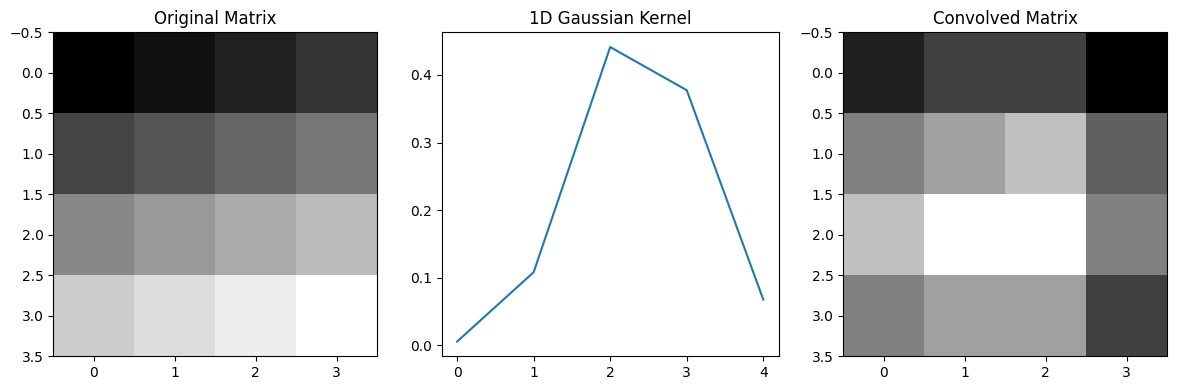

In [148]:
import numpy as np
import matplotlib.pyplot as plt



# Display results
print("Original Matrix:")
print(matrix)

print("\n1D Gaussian Kernel:")
print(kernel_1d)

print("\nConvolved Matrix:")
print(convolved_matrix)

# Optional: Plot the original matrix, kernel, and convolved matrix
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(matrix, cmap='gray', interpolation='nearest')
plt.title('Original Matrix')

plt.subplot(1, 3, 2)
plt.plot(kernel_1d)
plt.title('1D Gaussian Kernel')

plt.subplot(1, 3, 3)
plt.imshow(convolved_matrix, cmap='gray', interpolation='nearest')
plt.title('Convolved Matrix')

plt.tight_layout()
plt.show()

